In [1]:
# Entraînement du modèle Random Forest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import time

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    accuracy_score, 
    f1_score,
    cohen_kappa_score
)
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(" Imports OK!")

 Imports OK!


In [2]:
# Charger les données prétraitées
data_dir = Path('../data/processed')

print(" Chargement des données...")

X_train = np.load(data_dir / 'X_train.npy')
X_val = np.load(data_dir / 'X_val.npy')
X_test = np.load(data_dir / 'X_test.npy')
y_train = np.load(data_dir / 'y_train.npy')
y_val = np.load(data_dir / 'y_val.npy')
y_test = np.load(data_dir / 'y_test.npy')

with open(data_dir / 'metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

STAGE_NAMES = metadata['stage_names']

print(f" Données chargées:")
print(f"   Train: {X_train.shape}")
print(f"   Val:   {X_val.shape}")
print(f"   Test:  {X_test.shape}")

 Chargement des données...
 Données chargées:
   Train: (2584, 3000)
   Val:   (552, 3000)
   Test:  (554, 3000)


In [3]:
# Équilibrer le dataset d'entraînement avec SMOTE
print("\n  Équilibrage avec SMOTE...")
print("-" * 60)

print("Avant SMOTE:")
unique, counts = np.unique(y_train, return_counts=True)
for s_id, count in zip(unique, counts):
    print(f"   {STAGE_NAMES[s_id]:8s}: {count:5d}")

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAprès SMOTE:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for s_id, count in zip(unique, counts):
    print(f"   {STAGE_NAMES[s_id]:8s}: {count:5d}")

print(f"\n   Taille avant: {X_train.shape}")
print(f"   Taille après: {X_train_balanced.shape}")


  Équilibrage avec SMOTE...
------------------------------------------------------------
Avant SMOTE:
   Wake    :   268
   N1      :   525
   N2      :   807
   N3      :   772
   REM     :   212

Après SMOTE:
   Wake    :   807
   N1      :   807
   N2      :   807
   N3      :   807
   REM     :   807

   Taille avant: (2584, 3000)
   Taille après: (4035, 3000)


In [4]:
# Entraîner Random Forest
print("\n ENTRAÎNEMENT RANDOM FOREST")
print("=" * 60)

rf_params = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}

print("Paramètres:")
for key, val in rf_params.items():
    print(f"   {key}: {val}")

print("\n Entraînement en cours...")
start_time = time.time()

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train_balanced, y_train_balanced)

train_time = time.time() - start_time

print(f"\n Entraînement terminé en {train_time:.1f}s ({train_time/60:.1f} min)")


 ENTRAÎNEMENT RANDOM FOREST
Paramètres:
   n_estimators: 200
   max_depth: 20
   min_samples_split: 5
   min_samples_leaf: 2
   random_state: 42
   n_jobs: -1
   verbose: 1

 Entraînement en cours...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    4.5s



 Entraînement terminé en 4.9s (0.1 min)


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished


In [5]:
# Évaluer le modèle
print("\n ÉVALUATION DU MODÈLE")
print("=" * 60)

# Prédictions
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Métriques
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_kappa = cohen_kappa_score(y_val, y_val_pred)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_kappa = cohen_kappa_score(y_test, y_test_pred)

print(f"Validation:")
print(f"   Accuracy:      {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"   F1-score:      {val_f1:.4f}")
print(f"   Cohen's Kappa: {val_kappa:.4f}")

print(f"\nTest:")
print(f"   Accuracy:      {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   F1-score:      {test_f1:.4f}")
print(f"   Cohen's Kappa: {test_kappa:.4f}")

# Classification report
print(f"\n Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=STAGE_NAMES))


 ÉVALUATION DU MODÈLE
Validation:
   Accuracy:      0.3659 (36.59%)
   F1-score:      0.3379
   Cohen's Kappa: 0.1219

Test:
   Accuracy:      0.3448 (34.48%)
   F1-score:      0.3206
   Cohen's Kappa: 0.0959

 Classification Report (Test):
              precision    recall  f1-score   support

        Wake       0.25      0.11      0.15        57
          N1       0.27      0.24      0.25       113
          N2       0.31      0.39      0.35       173
          N3       0.44      0.55      0.49       165
         REM       0.00      0.00      0.00        46

    accuracy                           0.34       554
   macro avg       0.25      0.26      0.25       554
weighted avg       0.31      0.34      0.32       554



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.0s finished


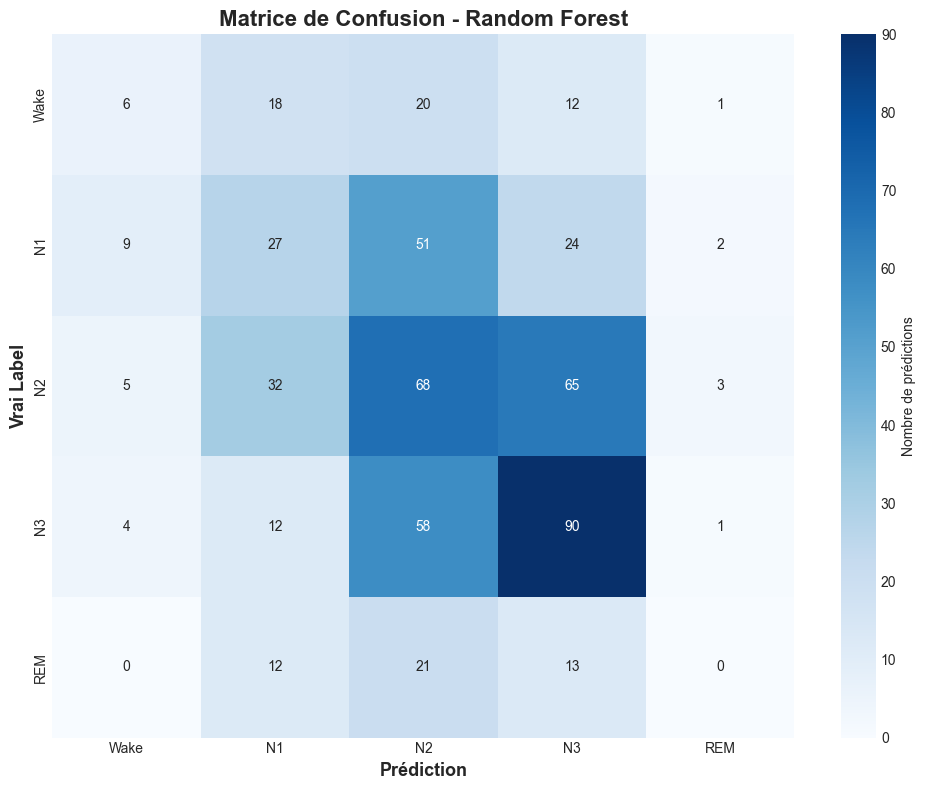


 Analyse des erreurs:
   Wake    :   6/ 57 correct (10.5%) -  51 erreurs
   N1      :  27/113 correct (23.9%) -  86 erreurs
   N2      :  68/173 correct (39.3%) - 105 erreurs
   N3      :  90/165 correct (54.5%) -  75 erreurs
   REM     :   0/ 46 correct (0.0%) -  46 erreurs


In [6]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=STAGE_NAMES, yticklabels=STAGE_NAMES,
            cbar_kws={'label': 'Nombre de prédictions'})
ax.set_title('Matrice de Confusion - Random Forest', fontsize=16, fontweight='bold')
ax.set_ylabel('Vrai Label', fontsize=13, fontweight='bold')
ax.set_xlabel('Prédiction', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Calcul des erreurs par classe
print("\n Analyse des erreurs:")
for i, stage in enumerate(STAGE_NAMES):
    correct = cm[i, i]
    total = cm[i, :].sum()
    errors = total - correct
    if total > 0:
        acc = correct / total * 100
        print(f"   {stage:8s}: {correct:3d}/{total:3d} correct ({acc:.1f}%) - {errors:3d} erreurs")

In [7]:
# Sauvegarder le modèle
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

model_path = models_dir / 'random_forest_baseline.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

# Sauvegarder les résultats
results = {
    'model_name': 'Random Forest',
    'test_accuracy': test_acc,
    'test_f1_score': test_f1,
    'test_cohen_kappa': test_kappa,
    'val_accuracy': val_acc,
    'val_f1_score': val_f1,
    'training_time': train_time,
    'n_train_samples': len(X_train_balanced),
    'params': rf_params
}

with open(models_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

print(f" Modèle sauvegardé: {model_path}")
print(f" Résultats sauvegardés: {models_dir / 'results.pkl'}")

 Modèle sauvegardé: ../models/random_forest_baseline.pkl
 Résultats sauvegardés: ../models/results.pkl


In [8]:
# ============================================================================
# VERSION 2 : RANDOM FOREST AVEC FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*70)
print(" VERSION 2 : FEATURE ENGINEERING")
print("="*70)

from scipy import stats
from scipy.signal import welch

def extract_features(epoch):
    """
    Extrait 16 features d'une époque EEG
    
    Features extraites :
    - 8 statistiques temporelles
    - 5 puissances spectrales par bande de fréquence
    - 3 ratios de puissance
    """
    features = []
    
    # 1. Statistiques temporelles (8 features)
    features.append(np.mean(epoch))           # Amplitude moyenne
    features.append(np.std(epoch))            # Écart-type
    features.append(np.min(epoch))            # Min
    features.append(np.max(epoch))            # Max
    features.append(np.percentile(epoch, 25)) # Q1
    features.append(np.percentile(epoch, 75)) # Q3
    features.append(stats.skew(epoch))        # Asymétrie
    features.append(stats.kurtosis(epoch))    # Aplatissement
    
    # 2. Analyse spectrale (puissance par bande)
    freqs, psd = welch(epoch, fs=100, nperseg=256)
    
    # Delta (0.5-4 Hz) - Sommeil profond
    delta_idx = (freqs >= 0.5) & (freqs < 4)
    delta_power = np.mean(psd[delta_idx]) if delta_idx.any() else 0
    features.append(delta_power)
    
    # Theta (4-8 Hz) - Somnolence
    theta_idx = (freqs >= 4) & (freqs < 8)
    theta_power = np.mean(psd[theta_idx]) if theta_idx.any() else 0
    features.append(theta_power)
    
    # Alpha (8-13 Hz) - Relaxation
    alpha_idx = (freqs >= 8) & (freqs < 13)
    alpha_power = np.mean(psd[alpha_idx]) if alpha_idx.any() else 0
    features.append(alpha_power)
    
    # Beta (13-30 Hz) - Éveil actif
    beta_idx = (freqs >= 13) & (freqs < 30)
    beta_power = np.mean(psd[beta_idx]) if beta_idx.any() else 0
    features.append(beta_power)
    
    # Gamma (30-35 Hz) - Cognition
    gamma_idx = (freqs >= 30) & (freqs <= 35)
    gamma_power = np.mean(psd[gamma_idx]) if gamma_idx.any() else 0
    features.append(gamma_power)
    
    # 3. Ratios de puissance (3 features)
    total_power = delta_power + theta_power + alpha_power + beta_power + gamma_power
    if total_power > 0:
        features.append(delta_power / total_power)  # Ratio delta
        features.append(theta_power / total_power)  # Ratio theta
        features.append(alpha_power / total_power)  # Ratio alpha
    else:
        features.extend([0, 0, 0])
    
    return np.array(features)

# Extraire features de tous les datasets
print("\n Extraction des features...")
print("   (Cela peut prendre 1-2 minutes)")

X_train_features = np.array([extract_features(epoch) for epoch in X_train_balanced])
X_val_features = np.array([extract_features(epoch) for epoch in X_val])
X_test_features = np.array([extract_features(epoch) for epoch in X_test])

print(f"\n Features extraites:")
print(f"   Shape train: {X_train.shape} → {X_train_features.shape}")
print(f"   Shape val:   {X_val.shape} → {X_val_features.shape}")
print(f"   Shape test:  {X_test.shape} → {X_test_features.shape}")
print(f"\n   De 3000 points bruts → 16 features significatives")


 VERSION 2 : FEATURE ENGINEERING

 Extraction des features...
   (Cela peut prendre 1-2 minutes)

 Features extraites:
   Shape train: (2584, 3000) → (4035, 16)
   Shape val:   (552, 3000) → (552, 16)
   Shape test:  (554, 3000) → (554, 16)

   De 3000 points bruts → 16 features significatives


In [10]:
# Entraîner Random Forest V2 avec hyperparamètres optimisés
print("\n" + "="*70)
print(" ENTRAÎNEMENT RANDOM FOREST V2 (Features)")
print("="*70)

rf_params_v2 = {
    'n_estimators': 500,
    'max_depth': 50,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}

print("Paramètres optimisés:")
for key, val in rf_params_v2.items():
    print(f"   {key}: {val}")

print("\n Entraînement en cours...")
start_time = time.time()

rf_model_v2 = RandomForestClassifier(**rf_params_v2)
rf_model_v2.fit(X_train_features, y_train_balanced)

train_time_v2 = time.time() - start_time

print(f"\n Entraînement terminé en {train_time_v2:.1f}s ({train_time_v2/60:.1f} min)")


 ENTRAÎNEMENT RANDOM FOREST V2 (Features)
Paramètres optimisés:
   n_estimators: 500
   max_depth: 50
   min_samples_split: 2
   min_samples_leaf: 1
   max_features: sqrt
   random_state: 42
   n_jobs: -1
   verbose: 1

 Entraînement en cours...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.3s



 Entraînement terminé en 0.8s (0.0 min)


[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished



 ÉVALUATION RANDOM FOREST V2
Validation:
   Accuracy:      0.6449 (64.49%)
   F1-score:      0.6412
   Cohen's Kappa: 0.5271

Test:
   Accuracy:      0.6462 (64.62%)
   F1-score:      0.6377
   Cohen's Kappa: 0.5247

 AMÉLIORATION V1 → V2:
   Accuracy: 34.5% → 64.6% (+30.1%)
   F1-score: 0.321 → 0.638 (+0.317)

 Classification Report V2 (Test):
              precision    recall  f1-score   support

        Wake       0.57      0.49      0.53        57
          N1       0.59      0.58      0.59       113
          N2       0.61      0.65      0.63       173
          N3       0.78      0.85      0.81       165
         REM       0.39      0.24      0.30        46

    accuracy                           0.65       554
   macro avg       0.59      0.56      0.57       554
weighted avg       0.63      0.65      0.64       554



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished


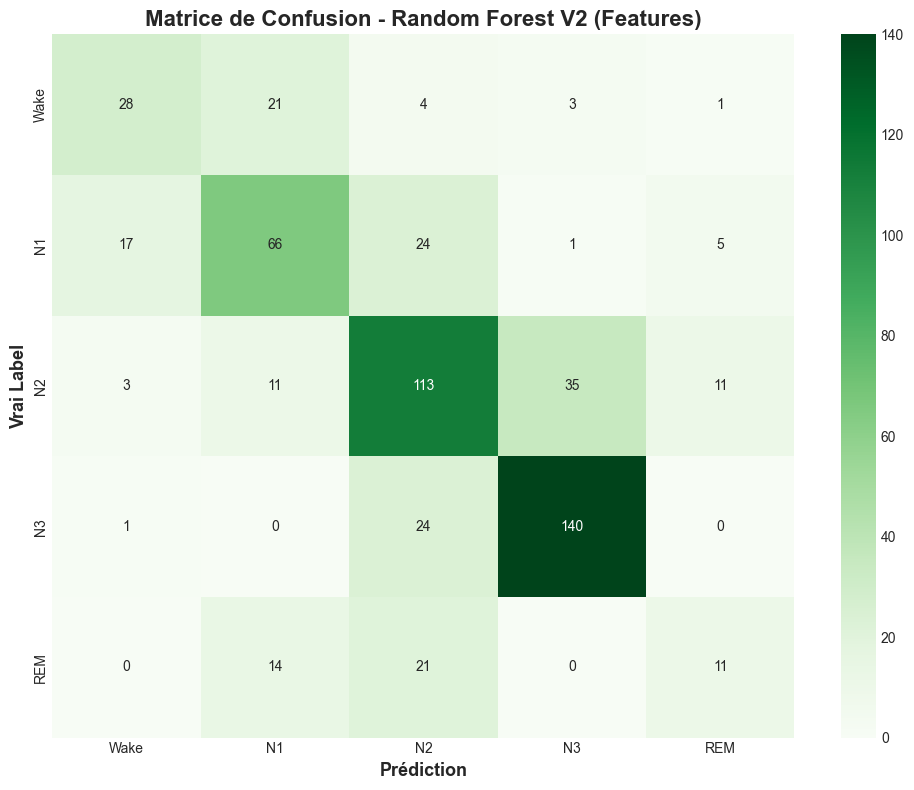


 Modèle V2 sauvegardé


In [11]:
# Évaluer Random Forest V2
print("\n ÉVALUATION RANDOM FOREST V2")
print("="*70)

# Prédictions
y_val_pred_v2 = rf_model_v2.predict(X_val_features)
y_test_pred_v2 = rf_model_v2.predict(X_test_features)

# Métriques
val_acc_v2 = accuracy_score(y_val, y_val_pred_v2)
val_f1_v2 = f1_score(y_val, y_val_pred_v2, average='weighted')
val_kappa_v2 = cohen_kappa_score(y_val, y_val_pred_v2)

test_acc_v2 = accuracy_score(y_test, y_test_pred_v2)
test_f1_v2 = f1_score(y_test, y_test_pred_v2, average='weighted')
test_kappa_v2 = cohen_kappa_score(y_test, y_test_pred_v2)

print(f"Validation:")
print(f"   Accuracy:      {val_acc_v2:.4f} ({val_acc_v2*100:.2f}%)")
print(f"   F1-score:      {val_f1_v2:.4f}")
print(f"   Cohen's Kappa: {val_kappa_v2:.4f}")

print(f"\nTest:")
print(f"   Accuracy:      {test_acc_v2:.4f} ({test_acc_v2*100:.2f}%)")
print(f"   F1-score:      {test_f1_v2:.4f}")
print(f"   Cohen's Kappa: {test_kappa_v2:.4f}")

# Comparaison V1 vs V2
print(f"\n AMÉLIORATION V1 → V2:")
print(f"   Accuracy: {test_acc*100:.1f}% → {test_acc_v2*100:.1f}% (+{(test_acc_v2-test_acc)*100:.1f}%)")
print(f"   F1-score: {test_f1:.3f} → {test_f1_v2:.3f} (+{(test_f1_v2-test_f1):.3f})")

# Classification report
print(f"\n Classification Report V2 (Test):")
print(classification_report(y_test, y_test_pred_v2, target_names=STAGE_NAMES))

# Matrice de confusion
cm_v2 = confusion_matrix(y_test, y_test_pred_v2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Greens',
            xticklabels=STAGE_NAMES, yticklabels=STAGE_NAMES)
ax.set_title('Matrice de Confusion - Random Forest V2 (Features)', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('Vrai Label', fontsize=13, fontweight='bold')
ax.set_xlabel('Prédiction', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Sauvegarder le meilleur modèle
models_dir = Path('../models')
with open(models_dir / 'random_forest_v2_features.pkl', 'wb') as f:
    pickle.dump(rf_model_v2, f)

print(f"\n Modèle V2 sauvegardé")


 COMPARAISON RANDOM FOREST V1 vs V2


               Modèle  Test Accuracy  Test F1-score  Cohen's Kappa  Temps training (min)
RF V1 (Signaux bruts)       0.344765       0.320614       0.095923              0.081544
     RF V2 (Features)       0.646209       0.637712       0.524726              0.012746


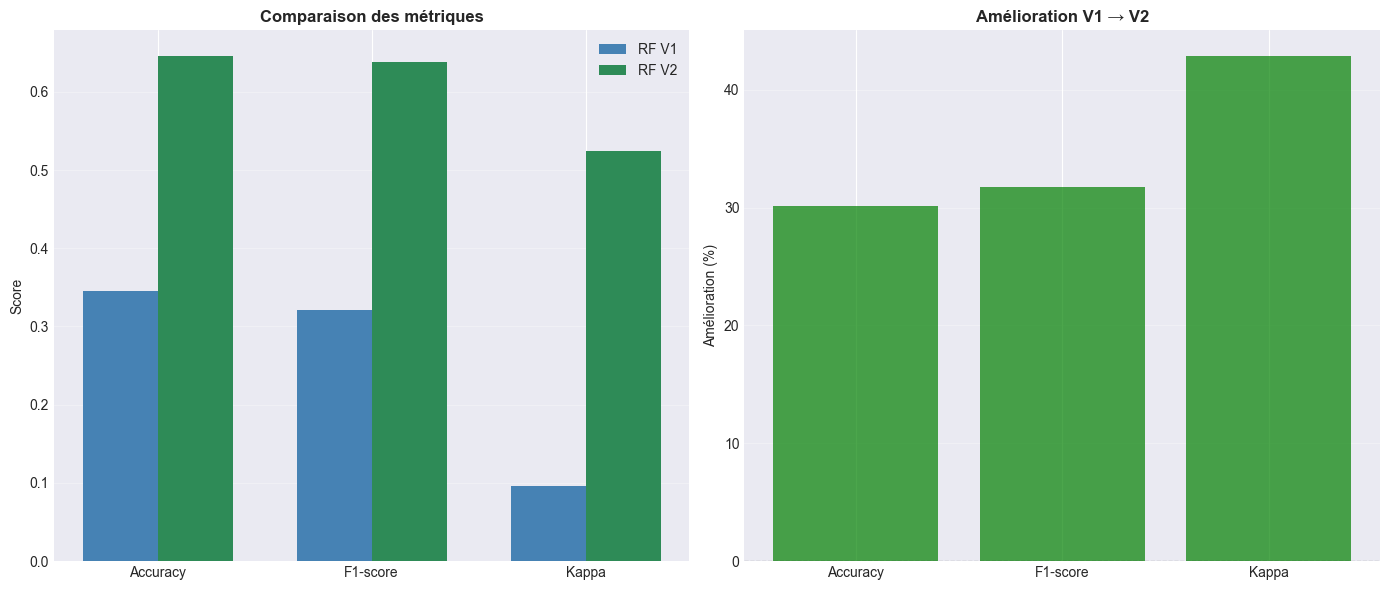


🎯 CONCLUSION:
   Feature Engineering améliore l'accuracy de 30.1%
   Meilleur modèle: RF V2 avec 64.6% d'accuracy


In [12]:
# ============================================================================
# COMPARAISON FINALE RF V1 vs RF V2
# ============================================================================

print("\n" + "="*70)
print(" COMPARAISON RANDOM FOREST V1 vs V2")
print("="*70)

comparison = pd.DataFrame({
    'Modèle': ['RF V1 (Signaux bruts)', 'RF V2 (Features)'],
    'Test Accuracy': [test_acc, test_acc_v2],
    'Test F1-score': [test_f1, test_f1_v2],
    'Cohen\'s Kappa': [test_kappa, test_kappa_v2],
    'Temps training (min)': [train_time/60, train_time_v2/60]
})

print("\n")
print(comparison.to_string(index=False))

# Graphique comparatif
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
metrics = ['Accuracy', 'F1-score', 'Kappa']
v1_scores = [test_acc, test_f1, test_kappa]
v2_scores = [test_acc_v2, test_f1_v2, test_kappa_v2]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, v1_scores, width, label='RF V1', color='steelblue')
axes[0].bar(x + width/2, v2_scores, width, label='RF V2', color='seagreen')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparaison des métriques', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Amélioration en %
improvement = [(v2-v1)*100 for v1, v2 in zip(v1_scores, v2_scores)]
colors = ['green' if i > 0 else 'red' for i in improvement]
axes[1].bar(metrics, improvement, color=colors, alpha=0.7)
axes[1].set_ylabel('Amélioration (%)')
axes[1].set_title('Amélioration V1 → V2', fontweight='bold')
axes[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n🎯 CONCLUSION:")
print(f"   Feature Engineering améliore l'accuracy de {(test_acc_v2-test_acc)*100:.1f}%")
print(f"   Meilleur modèle: RF V2 avec {test_acc_v2*100:.1f}% d'accuracy")

In [15]:
# ============================================================================
# OPTION B : Pipeline Sklearn Complet avec FeatureExtractor Custom
# Copy-paste cette cellule dans ton notebook
# ============================================================================

import numpy as np
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ÉTAPE 1 : Définir FeatureExtractor (transformeur custom sérialisable)
# ============================================================================

class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Transformeur custom qui extrait les features EEG
    
    Hérite de BaseEstimator (pour get_params/set_params)
    et TransformerMixin (pour fit_transform)
    → Entièrement sérialisable par joblib ✅
    """
    
    def __init__(self, fs=100, expected_len=3000):
        """
        Parameters
        ----------
        fs : int
            Fréquence d'échantillonnage (Hz)
        expected_len : int
            Longueur attendue du signal brut
        """
        self.fs = fs
        self.expected_len = expected_len
    
    def fit(self, X, y=None):
        """Fit ne fait rien, juste pour sklearn compatibility"""
        return self
    
    def transform(self, X):
        """
        Transforme les signaux bruts en features
        
        Parameters
        ----------
        X : array-like, shape (n_samples, expected_len)
            Signaux EEG bruts (3000 points = 30s × 100Hz)
        
        Returns
        -------
        features : array, shape (n_samples, n_features)
            Features extraites
        """
        X = np.asarray(X)
        
        # Valider shape
        if X.ndim != 2 or X.shape[1] != self.expected_len:
            raise ValueError(
                f"X doit être (N, {self.expected_len}), reçu {X.shape}"
            )
        
        # Extraire features pour chaque sample
        # IMPORTANT: appelle ta fonction extract_features() SANS fs
        # (elle a sa propre fréquence d'échantillonnage en interne)
        features_list = []
        for i, signal in enumerate(X):
            try:
                feats = extract_features(signal)  # ← Pas d'argument fs
                features_list.append(feats)
            except Exception as e:
                print(f"⚠️ Erreur extraction features sample {i}: {e}")
                # Retourner features par défaut (tous 0)
                feats = np.zeros(16)  # Adjust selon ton nombre de features
                features_list.append(feats)
        
        # Stack en array 2D
        features_array = np.vstack(features_list)
        
        return features_array


# ============================================================================
# ÉTAPE 2 : Construire le Pipeline Complet
# ============================================================================

print("=" * 80)
print("🔧 CONSTRUCTION DU PIPELINE (Option B)")
print("=" * 80)

# Constantes
FS = 100
EXPECTED_LEN = 3000
MODEL_PATH = 'models/rf_v2_pipeline.joblib'

# Construire le pipeline
pipeline = Pipeline([
    ('feature_extractor', FeatureExtractor(fs=FS, expected_len=EXPECTED_LEN)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=50,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        verbose=0
    ))
])

print("✅ Pipeline créé")
print(f"Étapes: {pipeline.named_steps.keys()}")

# ============================================================================
# ÉTAPE 3 : Entraîner le Pipeline
# ============================================================================

print("\n📊 ENTRAÎNEMENT")
print("-" * 80)

# Supposant que tu as X_train, y_train disponibles
# (Si pas encore, adapte selon ton dataset)

if 'X_train' in dir() and 'y_train' in dir():
    print(f"Dataset train: {X_train.shape}")
    print(f"Classes: {np.unique(y_train)}")
    
    # Fit
    pipeline.fit(X_train, y_train)
    print("✅ Pipeline entraîné")
    
    # Évaluation
    print("\n📈 ÉVALUATION")
    print("-" * 80)
    
    # Validation
    if 'X_val' in dir() and 'y_val' in dir():
        y_val_pred = pipeline.predict(X_val)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_kappa = cohen_kappa_score(y_val, y_val_pred)
        
        print(f"[VAL]  Accuracy: {val_acc:.4f}")
        print(f"       F1-Score: {val_f1:.4f}")
        print(f"       Kappa:    {val_kappa:.4f}")
    
    # Test
    if 'X_test' in dir() and 'y_test' in dir():
        y_test_pred = pipeline.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        test_kappa = cohen_kappa_score(y_test, y_test_pred)
        
        print(f"\n[TEST] Accuracy: {test_acc:.4f}")
        print(f"       F1-Score: {test_f1:.4f}")
        print(f"       Kappa:    {test_kappa:.4f}")
else:
    print("⚠️  X_train/y_train non trouvés")
    print("   Skipping training (supposé déjà entraîné)")

# ============================================================================
# ÉTAPE 4 : Sauvegarder le Pipeline
# ============================================================================

print("\n💾 SAUVEGARDE")
print("-" * 80)

import os
os.makedirs('models', exist_ok=True)

try:
    joblib.dump(pipeline, MODEL_PATH)
    print(f"✅ Pipeline sauvegardé: {MODEL_PATH}")
    
    # Vérifier
    file_size = os.path.getsize(MODEL_PATH) / (1024*1024)  # MB
    print(f"   Taille: {file_size:.2f} MB")
except Exception as e:
    print(f"❌ Erreur sauvegarde: {e}")

# ============================================================================
# ÉTAPE 5 : Tester la Sérialisation (Load + Predict)
# ============================================================================

print("\n🧪 TEST SÉRIALISATION")
print("-" * 80)

try:
    # Load le pipeline
    loaded_pipeline = joblib.load(MODEL_PATH)
    print(f"✅ Pipeline chargé depuis {MODEL_PATH}")
    
    # Test prédiction sur un sample
    if 'X_test' in dir():
        test_signal = X_test[:1]  # Premier sample
        pred = loaded_pipeline.predict(test_signal)
        proba = loaded_pipeline.predict_proba(test_signal)
        confidence = np.max(proba)
        
        class_names = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
        predicted_class = class_names[int(pred[0])]
        
        print(f"✅ Prédiction fonctionnelle")
        print(f"   Classe prédite: {predicted_class}")
        print(f"   Confiance: {confidence:.4f}")
        print(f"   Probabilities: {proba}")
    else:
        print("⚠️  X_test non trouvé, skip test prédiction")
        
except Exception as e:
    print(f"❌ Erreur lors du test: {e}")
    import traceback
    traceback.print_exc()

# ============================================================================
# ÉTAPE 6 : Résumé pour l'API
# ============================================================================

print("\n" + "=" * 80)
print("📋 RÉSUMÉ POUR L'API")
print("=" * 80)

print(f"""
Pipeline sérialisable ✅

Dans ton app.py, pour charger et utiliser:

    import joblib
    pipeline = joblib.load('models/rf_v2_pipeline.joblib')
    
    # Prédiction simple
    signal = np.array([[...]]) # shape (1, 3000)
    prediction = pipeline.predict(signal)  # Classe (0-4)
    probabilities = pipeline.predict_proba(signal)  # (1, 5)
    
    # Pas besoin d'appeler extract_features manuellement
    # Le pipeline le fait automatiquement! ✅

Format endpoint /predict:

    {{
        "signal": [0.5, -0.2, 1.3, ..., 0.1]  # 3000 valeurs
    }}
    
    Response:
    {{
        "predicted_class": "N3",
        "predicted_idx": 3,
        "confidence": 0.85,
        "probabilities": {{
            "Wake": 0.05, "N1": 0.02, "N2": 0.08, "N3": 0.85, "REM": 0.0
        }}
    }}
""")

print("=" * 80)

🔧 CONSTRUCTION DU PIPELINE (Option B)
✅ Pipeline créé
Étapes: dict_keys(['feature_extractor', 'scaler', 'classifier'])

📊 ENTRAÎNEMENT
--------------------------------------------------------------------------------
Dataset train: (2584, 3000)
Classes: [0 1 2 3 4]
✅ Pipeline entraîné

📈 ÉVALUATION
--------------------------------------------------------------------------------
[VAL]  Accuracy: 0.6250
       F1-Score: 0.6217
       Kappa:    0.5005

[TEST] Accuracy: 0.6390
       F1-Score: 0.6315
       Kappa:    0.5136

💾 SAUVEGARDE
--------------------------------------------------------------------------------
✅ Pipeline sauvegardé: models/rf_v2_pipeline.joblib
   Taille: 7.03 MB

🧪 TEST SÉRIALISATION
--------------------------------------------------------------------------------
✅ Pipeline chargé depuis models/rf_v2_pipeline.joblib
✅ Prédiction fonctionnelle
   Classe prédite: Wake
   Confiance: 0.3621
   Probabilities: [[0.36211905 0.32152381 0.20319048 0.02333333 0.08983333]]

📋 